In [1]:
# import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler


In [2]:
rune_data_filename = 'data/Rune_Data.csv'

rune_dataframe = pd.read_csv(rune_data_filename)
rune_dataframe.head()

,timestamp,Fire_rune,Water_rune,Air_rune,Earth_rune,Mind_rune,Body_rune,Death_rune,Nature_rune,Chaos_rune,Law_rune,Cosmic_rune,Blood_rune,Soul_rune
0,1562371200000,5,5,5,5,4,4,209,204,93,192,115,368,147
1,1562457600000,5,5,5,4,4,4,208,202,93,192,112,376,147
2,1562544000000,5,5,5,5,4,4,208,202,92,190,114,371,147
3,1562630400000,5,5,5,5,4,4,208,203,92,188,112,368,147
4,1562716800000,5,4,5,5,4,4,208,205,92,187,114,368,148


In [3]:
# def univariate_data(dataset, start_index, end_index, history_size, target_size):
#     data = []
#     labels = []
    
#     start_index = start_index + history_size
#     if end_index is None:
#         end_index = len(dataset) - target_size
    
#     for i in range(start_index, end_index):
#         indices = range(i-history_size, i)
#         # reshape data from (history_size) to (history_size, 1)
        
#         data.append(np.reshape(dataset[indices], (history_size, 1)))
#         labels.append(dataset[i+target_size])
#     return np.array(data), np.array(labels)

In [4]:
def univariate_data(dataset, history_size):
    inout_seq = []
    L = len(dataset)
    for i in range(L - history_size):
        train_seq = dataset[i:i+history_size]
        train_label = dataset[i+history_size:i+history_size+1]
        inout_seq.append((train_seq, train_label))
        
    return inout_seq

In [5]:
train_split = 120

In [6]:
uni_data = rune_dataframe['Nature_rune']
uni_data.index = rune_dataframe['timestamp']

uni_data.head()

timestamp
1562371200000    204
1562457600000    202
1562544000000    202
1562630400000    203
1562716800000    205
Name: Nature_rune, dtype: int64

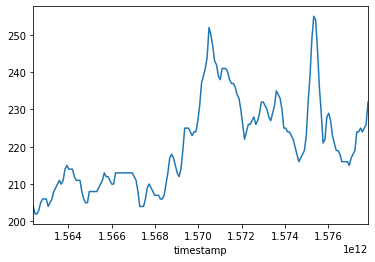

In [7]:
uni_data.plot()

In [8]:
uni_data = uni_data.values

In [9]:
uni_train_mean = uni_data[:train_split].mean()
uni_train_std = uni_data[:train_split].std()

In [10]:
# normalize data
scaler = MinMaxScaler(feature_range=(-1,1))

uni_data = scaler.fit_transform(uni_data.reshape(-1,1))
uni_data = torch.FloatTensor(uni_data)
print(uni_data[:5])

tensor([[-0.9245],
        [-1.0000],
        [-1.0000],
        [-0.9623],
        [-0.8868]])


In [11]:
uni_past_history = 10
uni_future_target = 0

In [12]:
# x_train_uni , y_train_uni = univariate_data(uni_data, 
#                                             0, 
#                                             train_split, 
#                                             uni_past_history, 
#                                             uni_future_target)
# x_val_uni, y_val_uni = univariate_data(uni_data, 
#                                        train_split, 
#                                        None, 
#                                        uni_past_history, 
#                                        uni_future_target)

train_inout_seq = univariate_data(uni_data, uni_past_history)

In [13]:
# print(x_train_uni.shape)
# print(y_train_uni.shape)
# print(x_train_uni[0])

In [14]:
print(len(train_inout_seq))
print(train_inout_seq[0])

170
(tensor([[-0.9245],
        [-1.0000],
        [-1.0000],
        [-0.9623],
        [-0.8868],
        [-0.8491],
        [-0.8491],
        [-0.8491],
        [-0.9245],
        [-0.8868]]), tensor([[-0.8491]]))


In [15]:
# print('Single window of past history')
# print(x_train_uni[0].shape)
# print('\n Target to predict')
# print(y_train_uni[0])

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [17]:
class RnnModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim):
        super().__init__()
        
        # define some parameters
        self.hidden_dim = hidden_dim

        # define layers
        # RNN layers
        self.lstm = nn.LSTM(input_size, hidden_dim)
        #FC layers
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        x = x.to(device)
        # set initial hidden and cell states
        h0 = torch.zeros(1,1,self.hidden_dim).to(device)
        c0 = torch.zeros(1,1,self.hidden_dim).to(device)
        # forward propagate 
#         print(h0.size())
#         print(c0.size())
#         print(x.size())
#         print(x.view(len(x),1,-1).size())
        out, _ = self.lstm(x.view(len(x),1,-1), (h0, c0))
        
        # decode hidden of last time step
        
        out = self.fc(out.view(len(x), -1))
        
        
        return out[-1]


In [18]:
# input_seq = torch.from_numpy(x_train_uni)
# target_seq = torch.Tensor(y_train_uni)

# input_seq.size()

In [19]:
model = RnnModel(input_size=1, output_size=1, hidden_dim=100)
# hyperparameters
n_epochs = 250
lr = .01

# define loss and optimizer 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [20]:
print(model)

RnnModel(
  (lstm): LSTM(1, 100)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


In [21]:
model.to(device)
# input_seq.to(device)
# target_seq.to(device)
for epoch in range(n_epochs):
    for seq, labels in train_inout_seq:

        seq.to(device)
        labels = labels.squeeze(1)

        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

    if epoch%10 == 0:
        print(f'Epoch: {epoch}/{n_epochs}.........')
        print(f'Loss: {loss.item()}')
    

Epoch: 0/250.........
Loss: 0.11481744050979614
Epoch: 10/250.........
Loss: 0.036351144313812256
Epoch: 20/250.........
Loss: 0.07642073184251785
Epoch: 30/250.........
Loss: 0.033523138612508774
Epoch: 40/250.........
Loss: 0.06448481976985931
Epoch: 50/250.........
Loss: 0.05795537680387497
Epoch: 60/250.........
Loss: 0.044275395572185516
Epoch: 70/250.........
Loss: 0.028493287041783333
Epoch: 80/250.........
Loss: 0.03322823718190193
Epoch: 90/250.........
Loss: 0.018639106303453445
Epoch: 100/250.........
Loss: 0.04359207674860954
Epoch: 110/250.........
Loss: 0.09091338515281677
Epoch: 120/250.........
Loss: 0.021335439756512642
Epoch: 130/250.........
Loss: 0.030829496681690216
Epoch: 140/250.........
Loss: 0.03154004365205765
Epoch: 150/250.........
Loss: 0.016534866765141487
Epoch: 160/250.........
Loss: 0.0120416060090065
Epoch: 170/250.........
Loss: 0.01616058312356472
Epoch: 180/250.........
Loss: 0.02623261697590351
Epoch: 190/250.........
Loss: 0.0015863297739997506
Ep

In [22]:
fut_pred = 10

test_inputs = uni_data[-uni_past_history:].squeeze(1).tolist()
print(test_inputs)

[-0.43396225571632385, -0.3962264060974121, -0.35849055647850037, -0.16981132328510284, -0.16981132328510284, -0.1320754736661911, -0.16981132328510284, -0.1320754736661911, -0.09433962404727936, 0.1320754736661911]


In [23]:
model.eval()

for i in range(uni_past_history):
    print(len(test_inputs))
    seq = torch.FloatTensor(test_inputs[-uni_past_history:])
    with torch.no_grad():
        test_inputs.append(model(seq).item())
        
print(test_inputs)        

10
11
12
13
14
15
16
17
18
19
[-0.43396225571632385, -0.3962264060974121, -0.35849055647850037, -0.16981132328510284, -0.16981132328510284, -0.1320754736661911, -0.16981132328510284, -0.1320754736661911, -0.09433962404727936, 0.1320754736661911, 0.23976589739322662, 0.24372966587543488, 0.13113735616207123, -0.13571734726428986, -0.36557623744010925, -0.43509966135025024, -0.6443831324577332, -0.9086284637451172, -1.3575074672698975, -2.2356410026550293]


In [24]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[10:]).reshape(-1,1))
print(actual_predictions)

[[234.85379628]
 [234.95883615]
 [231.97513994]
 [224.9034903 ]
 [218.81222971]
 [216.96985897]
 [211.42384699]
 [204.42134571]
 [192.52605212]
 [169.25551343]]


In [25]:
print(uni_data)

tensor([[-0.9245],
        [-1.0000],
        [-1.0000],
        [-0.9623],
        [-0.8868],
        [-0.8491],
        [-0.8491],
        [-0.8491],
        [-0.9245],
        [-0.8868],
        [-0.8491],
        [-0.7736],
        [-0.7358],
        [-0.6981],
        [-0.6604],
        [-0.6981],
        [-0.6604],
        [-0.5472],
        [-0.5094],
        [-0.5472],
        [-0.5472],
        [-0.5472],
        [-0.6226],
        [-0.6604],
        [-0.6604],
        [-0.6604],
        [-0.7736],
        [-0.8491],
        [-0.8868],
        [-0.8868],
        [-0.7736],
        [-0.7736],
        [-0.7736],
        [-0.7736],
        [-0.7736],
        [-0.7358],
        [-0.6981],
        [-0.6604],
        [-0.5849],
        [-0.6226],
        [-0.6226],
        [-0.6604],
        [-0.6981],
        [-0.6981],
        [-0.5849],
        [-0.5849],
        [-0.5849],
        [-0.5849],
        [-0.5849],
        [-0.5849],
        [-0.5849],
        [-0.5849],
        [-0.

In [26]:
x = np.arange(170,180,1)

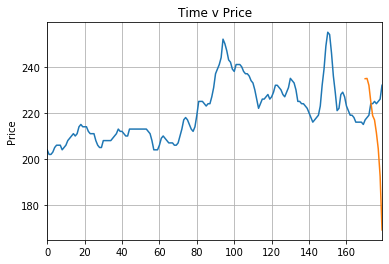

In [27]:
plt.title("Time v Price")
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(scaler.inverse_transform(uni_data))
plt.plot(x, actual_predictions)
plt.show()

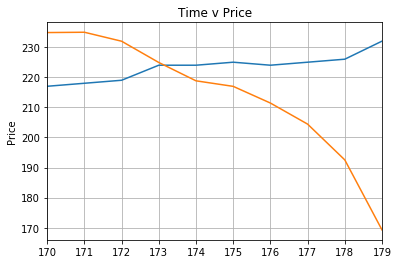

In [28]:
plt.title('Time v Price')
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(x,scaler.inverse_transform(uni_data)[-uni_past_history:])
plt.plot(x,actual_predictions)
plt.show()